# Nursery Scenario

In [1]:
from NN import *
from LTL import *

from csrl.mdp import GridMDP
from csrl.oa import OmegaAutomaton
from csrl import ControlSynthesis
import numpy as np
from matplotlib import pyplot as plt
import time

Number of Omega-automaton states (including the trap state): 58


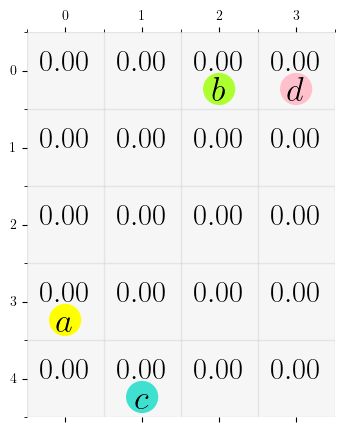

In [2]:
### from the Nursary case ###
# LTL Specification
# ltl = ('G ('
#     '(!d) & '
#     '((b & (!(X b)))->(X ((!b) U (a|c)))) & '
#     '(((!b) & (X b) & (!(X X b)))->((!a) U c)) & '
#     '(a->(X ((!a) U b))) & '
#     '(c->((!a) U b)) & '
#     '((b & (X b))->(F a))'
# ')')

ltl = ('G ('
    '(!d) & '
    '(c->((!a) U b)) & '
    '((b & (X b))->(F a)) & '
    '((b & (!(X b)))->(X ((!b) U (a|c)))) & '
    '(((!b) & (X b) & (!(X X b)))->((!a) U c)) &'
    '(a->(X ((!a) U b))) '
')')

# Translate the LTL formula to an LDBA
oa = OmegaAutomaton(ltl)
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])

# MDP Description
shape = (5,4)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E'],
# ['E',  'E',  'E',  'E'],
# ['E',  'E',  'E',  'E'],
# ['E',  'E',  'E',  'E'],
# ['E',  'E',  'E',  'E'],
# ['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E']
])

# Labels of the states
label = np.array([
[(),    (),    ('b',),('d',)],
[(),    (),    (),    ()],
# [(),    (),    (),    ()],
# [(),    (),    (),    ()],
# [(),    (),    (),    ()],
# [(),    (),    (),    ()],
# [(),    (),    (),    ()],
[(),    (),    (),    ()],
[('a',),(),    (),    ()],
[(),    ('c',),(),    ()]
],dtype=object)
# Colors of the labels
lcmap={
    ('a',):'yellow',
    ('b',):'greenyellow',
    ('c',):'turquoise',
    ('d',):'pink'
}
p = 1
grid_mdp = GridMDP(shape=shape,structure=structure,label=label,lcmap=lcmap, p=p, figsize=5)  # Use figsize=4 for smaller figures
grid_mdp.plot()

# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa)
max_rew = round(csrl.reward.max(), 3)

In [3]:
csrl.shape, csrl.ch_states[(0,0,0,0)].shape, max_rew

((1, 58, 5, 4, 62), (5, 4, 58), 0.01)

In [4]:
model = build_model(csrl.ch_states[(0,0,0,0)].shape, csrl.shape[-1])
model.summary()

In [13]:
t = "[] ( (~d) /\ (c->(~a % b)) /\ ((b /\ >b) -> <>a) /\ ((b /\ ~>b) -> >(~b % (a \/ c))) /\ ((~b /\ >b /\ ~>>b)->(~a % c)) )"

full_t = "[] ( (~d) /\ ((b /\ ~>b) -> >(~b % (a \/ c))) /\ (a -> >(~a % b))"
full_t += " /\ ((~b /\ >b /\ ~>>b)->(~a % c)) /\ (c->(~a % b)) /\ ((b /\ >b) -> <>a) )"

LTL_formula = parser.parse(full_t)
predicates=grid_mdp.get_predicates()

### proof of satifying trajectory ###
tra = [2,3]
print(len(tra), check_LTL(LTL_formula, tra, predicates))
#######

2 []


In [14]:
predicates

{'a': [12], 'b': [2], 'c': [17], 'd': [3]}

In [15]:
model = build_model(csrl.ch_states[(0,0,0,0)].shape, csrl.shape[-1])

N, W, Q, P = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape)

In [1]:
model = build_model(csrl.ch_states[(0,0,0,0)].shape, csrl.shape[-1])

num_training_epochs = 100
num_test_epochs = 20
training = True
epochs = 20
T = [30]
K = 1
search_depth = 150

success_rates = []
succes_std = []
win_hist = []
train_history = []

for i in T:
    # TRAIN
    train_wins = 0
    N, W, Q, P = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape)
    for epoch in range(num_training_epochs):
        t1 = time.time()
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = csrl.MC_learning(model, LTL_formula, predicates,
                N = N, W = W, Q = Q, P = P, C=3, tow=1, n_samples=100, start=(4,1), search_depth=search_depth,
                verbose=0, T=i, K=K)
        print(N[0])
        t2 = time.time()
        # print(t2-t1, " run episode")

        win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if win: train_wins+=1

        t3= time.time()
        if training and len(action_history)>0:
            x_train = np.array(channeled_states)
            y1_train = np.array(better_policy)
            y2_train = np.array(reward_history) + (check_LTL(LTL_formula, trajectory, predicates)[0]*max_rew)
            tr_hist = model.fit(x_train[:-1], [y1_train, y2_train[:-1]], epochs=epochs, verbose=0)
            train_history += tr_hist.history['loss']
        win_hist.append(win)
        t4 = time.time()
        # print(t4-t3, " fit")
    print("Train wins:",train_wins,"/", num_training_epochs)

    # TEST
    test_wins = 0
    N, W, Q, P = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape)
    for epoch in range(num_test_epochs):

        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = csrl.MC_learning(model, LTL_formula, predicates,
                N = N, W = W, Q = Q, P = P, C=3, tow=1, n_samples=100, start=(4,1), search_depth=search_depth, verbose=0, T=i, K=1)

        win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if win: test_wins+=1
        win_hist.append(win)

    success_rates.append(100*test_wins/num_test_epochs)
    temp = np.zeros(num_test_epochs)
    temp[:test_wins]=1
    std = np.sqrt(num_test_epochs*np.var(temp))
    succes_std.append((success_rates[-1]-std, success_rates[-1]+std))
    ###############################################################
    print("Test wins:",test_wins,"/",num_test_epochs)
    # print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    # print("Actions:", action_history)

NameError: name 'build_model' is not defined

In [28]:
bk_wins = win_hist.copy()

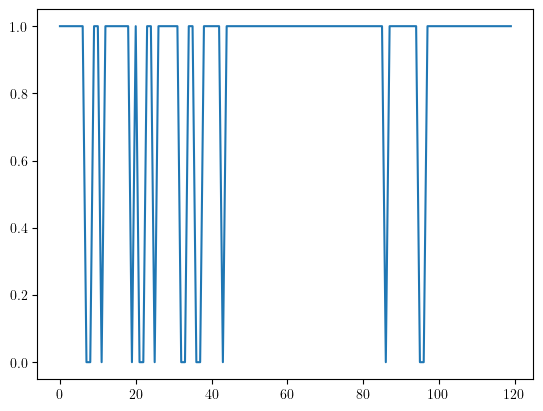

In [22]:
plt.plot(win_hist)

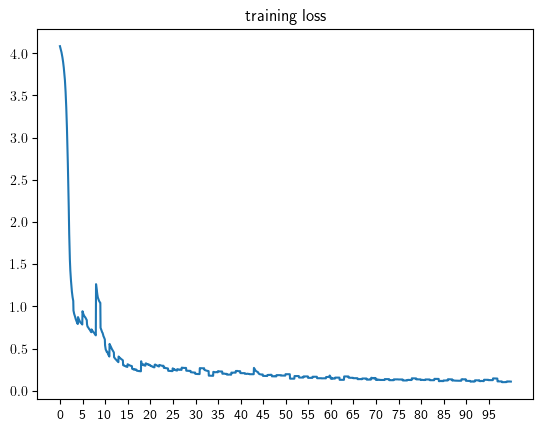

In [42]:
plt.plot(train_history)
plt.title("training loss")
plt.xticks(range(1,num_training_epochs*epochs,100), range(0,num_training_epochs,100//epochs));

In [33]:
len(range(1,2000,100))

20

In [41]:
model.save_weights('models/Nurseryp1')

In [62]:
model.load_weights('models/Nurseryp1')

Text(0.5, 1.0, 'MCTS(sd=max) adaptive training, nursery case, P=0.8')

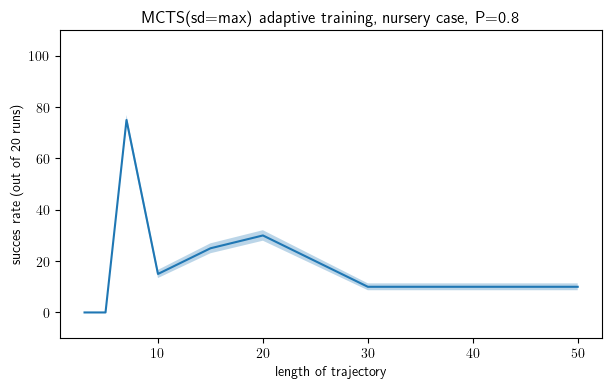

In [91]:
succes_std = np.array(succes_std)

plt.figure(figsize=(7,4))
plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3, label="MCTS area of 1 STD")

plt.plot(T, success_rates)
plt.ylim(-10, 110)
plt.xlabel("length of trajectory")
plt.ylabel(f"succes rate (out of {num_test_epochs} runs)")
plt.title("MCTS(sd=max) adaptive training, nursery case, P="+str(p))

In [37]:
from ipywidgets.widgets import IntSlider
from ipywidgets import interact

def plot_agent(t):
    csrl.mdp.plot(agent=state_history[t][2:], save=f'test/{t}.png')
t=IntSlider(value=0,min=0,max=T[-1]-1)
interact(plot_agent,t=t)

interactive(children=(IntSlider(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_agent(t)>

In [12]:
csrl.reward[0,3,4,1]

0.0

In [13]:
Q = (N/N.max())

In [65]:
Q=csrl.q_learning(T=100,K=100000)

In [66]:
policy=np.argmax(Q,axis=4)
value=np.max(Q,axis=4)

In [13]:
policy=np.argmax(Q,axis=4)
# csrl.plot(value,policy,iq=(0,0),save='safe_absorbing_states_policy.pdf')
csrl.plot(value,policy)

interactive(children=(IntSlider(value=0, description='i', max=0), IntSlider(value=0, description='q', max=57),…

In [87]:
rewards_mean = []
rewards_std = []
n_runs = 100

x = list(range(3,100,2))+[100]
for i in x:
    episodes, rew = csrl.run_Q_test(policy, LTL_formula, predicates, T=i, start=(4,1), runs=n_runs, verbose=0)
    rewards_mean.append(100*np.mean(rew))
    rewards_std.append((rewards_mean[-1]-np.sqrt(n_runs*np.var(rew)), rewards_mean[-1]+np.sqrt(n_runs*np.var(rew))))
rewards_std = np.array(rewards_std)

Running 100 simulations with 3 time-steps...
Test finished with:
	success rate: 0 / 100 = 0.0
Running 100 simulations with 5 time-steps...
Test finished with:
	success rate: 33 / 100 = 0.33
Running 100 simulations with 7 time-steps...
Test finished with:
	success rate: 23 / 100 = 0.23
Running 100 simulations with 9 time-steps...
Test finished with:
	success rate: 11 / 100 = 0.11
Running 100 simulations with 11 time-steps...
Test finished with:
	success rate: 11 / 100 = 0.11
Running 100 simulations with 13 time-steps...
Test finished with:
	success rate: 10 / 100 = 0.1
Running 100 simulations with 15 time-steps...
Test finished with:
	success rate: 26 / 100 = 0.26
Running 100 simulations with 17 time-steps...
Test finished with:
	success rate: 27 / 100 = 0.27
Running 100 simulations with 19 time-steps...
Test finished with:
	success rate: 26 / 100 = 0.26
Running 100 simulations with 21 time-steps...
Test finished with:
	success rate: 20 / 100 = 0.2
Running 100 simulations with 23 time-s

Text(0.5, 1.0, 'CSRL performance results on the second case study, P=0.8')

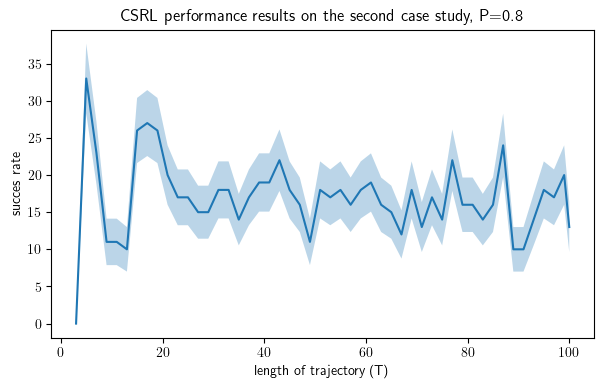

In [88]:
plt.figure(figsize=(7,4))
plt.fill_between(x, rewards_std[:,0], rewards_std[:,1], alpha=0.3, label="1 STD")

plt.plot(x, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate")
plt.title("CSRL performance results on the second case study, P="+str(p))

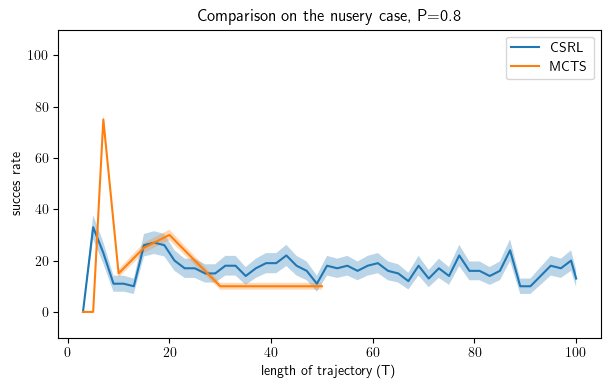

In [92]:
plt.figure(figsize=(7,4))

plt.fill_between(x, rewards_std[:,0], rewards_std[:,1], alpha=0.3)
plt.plot(x, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate")
plt.title("Comparison on the nusery case, P="+str(p))
plt.ylim(-10, 110)

plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3)
plt.plot(T, success_rates, label="MCTS")
plt.legend()

In [13]:
episode=csrl.simulate(policy, LTL_formula, predicates, start=(4,1),T=100)
episode[1]

interactive(children=(IntSlider(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',…

True

In [21]:
episode, rew =csrl.simulate(policy, LTL_formula, predicates, start=(9,1),T=100,plot=True)
elements, counts = np.unique(np.array(episode)[:,1], return_counts=True)
sorted(zip(elements,counts),key=lambda x:-x[1])

interactive(children=(IntSlider(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',…

[(21, 39), (24, 36), (14, 5), (4, 4), (8, 4), (9, 4), (23, 4), (26, 4), (0, 1)]

In [22]:
episodes, rewards = csrl.run_Q_test(policy, LTL_formula, predicates, start=(9,1),T=100, runs=100, verbose=0)

Running 100 simulations with 100 time-steps...
Test finished with:
	success rate: 0 / 100 = 0.0


In [ ]:
def plot_agent(t):
    csrl.mdp.plot(agent=state_history[t][2:], save=f'test/{t}.png')
t=IntSlider(value=0,min=0,max=T-1)
interact(plot_agent,t=t)

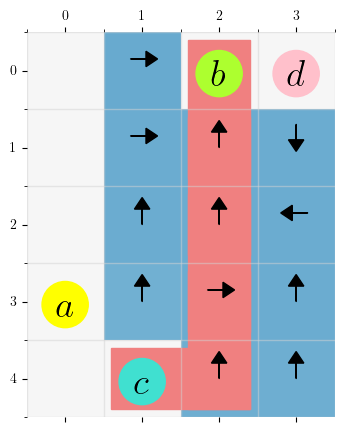

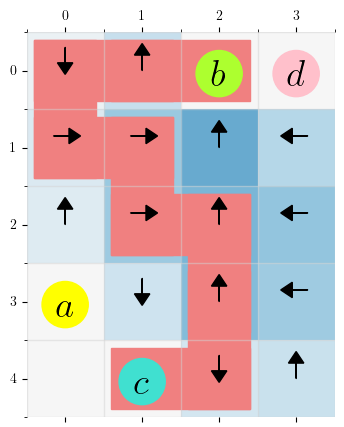

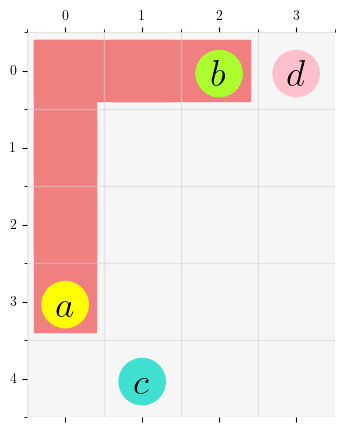

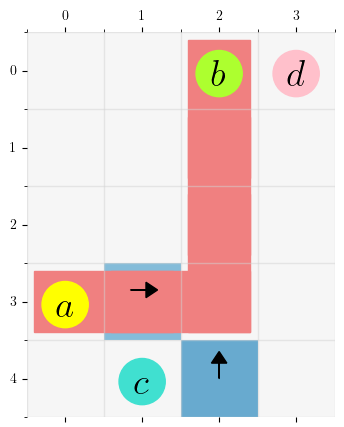

In [26]:
# Plot the important parts of the policy

policy=np.argmax(Q,axis=4)

hidden = [(0,0),(1,0),(2,0),(3,0),(4,0),(4,1),(0,2),(0,3)]
path = {
    (4,1) : 'r',
    (4,2) : 'lu',
    (3,2) : 'du',
    (2,2) : 'du',
    (1,2) : 'du',
    (0,2) : 'd'
}
csrl.plot(value,policy,iq=(0,2),save='nursery_scenario_policy_cb.pdf',path=path,hidden=hidden)


hidden = [(3,0),(4,0),(4,1),(0,2),(0,3)]
path = {
    (0,2) : 'l',
    (0,1) : 'lr',
    (0,0) : 'rd',
    (1,0) : 'ur',
    (1,1) : 'ld',
    (2,1) : 'ur',
    (2,2) : 'ld',
    (3,2) : 'ud',
    (4,2) : 'ul',
    (4,1) : 'r'
}
csrl.plot(value,policy,iq=(0,41),save='nursery_scenario_policy_bc.pdf',hidden=hidden,path=path)

hidden=[(3,0),(4,0),(4,1),(4,2),(4,3),(0,2),(0,3)]
path = {
    (0,2) : 'l',
    (0,1) : 'lr',
    (0,0) : 'rd',
    (1,0) : 'ud',
    (2,0) : 'ud',
    (3,0) : 'u'
}
csrl.plot(value,policy,iq=(0,12),save='nursery_scenario_policy_ba.pdf',hidden=hidden,path=path)

hidden=[(3,0),(4,0),(0,2),(0,3),(4,1)]
path = {
    (3,0) : 'r',
    (3,1) : 'lr',
    (3,2) : 'lu',
    (2,2) : 'du',
    (1,2) : 'du',
    (0,2) : 'd'
}
csrl.plot(value,policy,iq=(0,9),save='nursery_scenario_policy_ab.pdf',hidden=hidden,path=path)

In [14]:
# Save the animation
episode=csrl.simulate(policy,start=(4,1),T=100, animation='test')

interactive(children=(IntSlider(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',…